In [ ]:
%reload_ext autoreload
%autoreload 2

from pathlib import Path

try:
    WORKING_DIR
except NameError:
    WORKING_DIR = Path.cwd().parent

%cd $WORKING_DIR
%pwd

In [2]:
import torch
import pytorch_lightning as pl
import warnings

from src.datasets import GroupedMNISTDataModule, MultiMNISTDataModule, MTFLDataModule
from src.models import Ours, MTVIB
from src.evaluators import *
from src.utils import *

warnings.filterwarnings("ignore")

# GroupedMNIST and MultiMNIST
econfig = ExperimentConfig(
    enc_hidden_dims=[32, 32],
    latent_dim=4,
    pred_hidden_dims=[],
    beta=0.1,
    lr=1e-3,
    with_filter=True,
    with_weights=False,
    pretrained=False,
    seed=1234,
    max_epochs=25
)

if hasattr(econfig, "seed"):
    pl.seed_everything(econfig.seed, workers=True)

# GroupedMNIST
datamodule_config = dict(
    kind="pos",
    num_subgroups=4,
    num_elements=3,
    val_prop=0.1,
    data_dir="datasets/",
    num_workers=2,
    batch_size=128,
    pin_memory=False,
    seed=1234
)

# MultiMNIST
# datamodule_config = dict(
#     val_prop=0.1,
#     data_dir="datasets/",
#     batch_size=128,
#     pin_memory=False,
#     seed=1234
# )



Global seed set to 1234


In [3]:
# Init Dataset
datamodule = GroupedMNISTDataModule(**datamodule_config)
# datamodule = MultiMNISTDataModule(**datamodule_config)
# datamodule = MTFLDataModule(**datamodule_config)
datamodule.setup()

dconfig = DatasetConfig(
    **getattr(datamodule, "get_model_kwargs", lambda: {})()
)

# Init Model
model = Ours(
    econfig=econfig,
    dconfig=dconfig
)


# Init trainer
callbacks = [
    pl.callbacks.ModelCheckpoint(
        monitor="val/loss",
        mode="min",
        save_top_k=1,
        save_last=True,
        verbose=False,
        dirpath="checkpoints/",
        filename="epoch_{epoch:03d}",
        auto_insert_metric_name=False
    )
]

trainer_config = dict(
    max_epochs=econfig.max_epochs,
    callbacks=callbacks,
    check_val_every_n_epoch=1,
    accelerator="gpu",
    gpus=1,
)
trainer = pl.Trainer(**trainer_config)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [4]:
trainer.fit(
    model=model,
    train_dataloaders=datamodule.train_dataloader(),
    val_dataloaders=datamodule.val_dataloader()
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | encoder           | MLPBlock   | 26.3 K
1 | predictors        | ModuleList | 80    
2 | filter            | ModuleDict | 48    
3 | prediction_losses | ModuleList | 0     
4 | train_metrics     | ModuleList | 0     
5 | val_metrics       | ModuleList | 0     
6 | test_metrics      | ModuleList | 0     
-------------------------------------------------
26.4 K    Trainable params
16        Non-trainable params
26.4 K    Total params
0.106     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [5]:
trainer.test(
    model=model, dataloaders=datamodule.test_dataloader()
);

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test/acc-0         │    0.6858974099159241     │
│        test/acc-1         │    0.7030248641967773     │
│        test/acc-2         │    0.7019230723381042     │
│        test/acc-3         │    0.7033253312110901     │
│        test/avg_z         │    0.0985608622431755     │
│         test/beta         │    0.09999993443489075    │
│         test/kl-0         │       143.689453125       │
│         test/kl-1         │    135.29412841796875     │
│         test/kl-2         │    137.58370971679688     │
│         test/kl-3         │    138.06246948242188     │
│        test/kldiv         │     554.6300048828125     │
│         test/loss         │     597.9435424804688     │
│       test/ploss-0        │    116.27277374267578     │
│       test/ploss-1        │    128.94924926757812     │
│       test/ploss-2        │    149.00698852539062     │
│       test/ploss-3        │    148.25157165527344     │
│      test/pred_loss       │     542.4807739257812     │
└───────────────────────────┴───────────────────────────┘

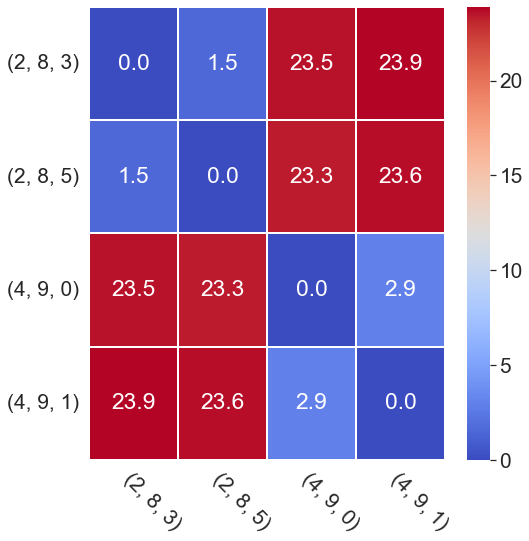

In [6]:
if isinstance(model, Ours):
    n_logvars = get_n_logvars(model)
    dist = distance_matrix(n_logvars)
    fig = distances_heatmap(dist, labels=dconfig.target_names)
    plt.show()

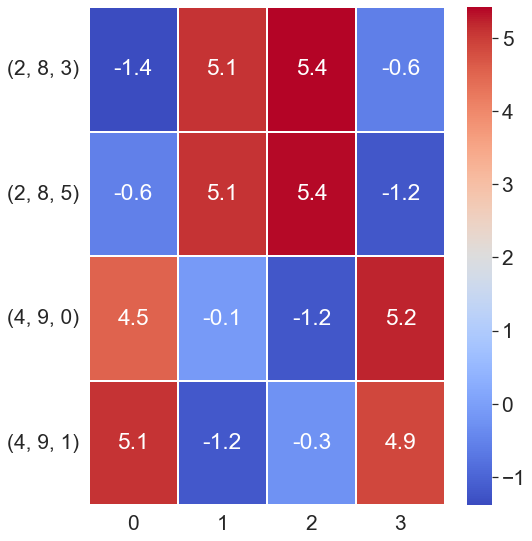

In [7]:
if isinstance(model, Ours):
    fig = vectors_heatmap(n_logvars, labels=dconfig.target_names)
    plt.show()